In [6]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import pickle
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score

In [7]:
import keras
import tensorflow as tf

In [8]:
from keras.layers import Input, Dense
from keras.models import Model

In [9]:
elem_labels = [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0]
class_labels = [0., -211., -13., -11., 1., 2., 11.0, 13., 22., 130., 211.]

In [10]:
Xs = []
ys = []
for iev in range(1, 60):
    for ifile in range(10):
        data = pickle.load(open("../data/TTbar_14TeV_TuneCUETP8M1_cfi/raw/pfntuple_{}_{}.pkl".format(iev, ifile), "rb"), encoding='iso-8859-1')
        Xelem = data[0]["Xelem"]
        ygen = data[0]["ygen"]
        Xelem[:, 0] = [int(elem_labels.index(i)) for i in Xelem[:, 0]]
        ygen[:, 0] = [int(class_labels.index(i)) for i in ygen[:, 0]]
        Xs += [Xelem.copy()]
        ys += [ygen.copy()]
        del data

In [11]:
Xs_training = Xs[:500]
ys_training = ys[:500]

Xs_testing = Xs[500:]
ys_testing = ys[500:]

In [12]:
def dist(A,B):
    na = tf.reduce_sum(tf.square(A), 1)
    nb = tf.reduce_sum(tf.square(B), 1)

    na = tf.reshape(na, [-1, 1])
    nb = tf.reshape(nb, [1, -1])
    D = tf.sqrt(tf.maximum(na - 2*tf.matmul(A, B, False, True) + nb, 0.0))
    return D

In [13]:
class InputEncoding(tf.keras.layers.Layer):
    def __init__(self, num_input_classes):
        super(InputEncoding, self).__init__()
        self.num_input_classes = num_input_classes
        
    def call(self, X):
        Xid = tf.one_hot(tf.cast(X[:, 0], tf.int32), self.num_input_classes)
        Xprop = X[:, 1:]
        return tf.concat([Xid, Xprop], axis=-1)
    
class Distance(tf.keras.layers.Layer):

    def __init__(self, *args, **kwargs):
        super(Distance, self).__init__(*args, **kwargs)

    def call(self, inputs):
        
        #compute the pairwise distance matrix between the vectors defined by the first two components of the input array
        D =  dist(inputs[:, :2], inputs[:, :2])
        
        #closer nodes have higher weight, could also consider exp(-D) or such here
        D = tf.math.divide_no_nan(1.0, D)
        
        #turn edges on or off based on activation with an arbitrary shift parameter
        D = tf.keras.activations.sigmoid(D - 5.0)
        
        #keep only upper triangular matrix (unidirectional edges)
        D = tf.linalg.band_part(D, 0, -1)
        return D
    
class GraphConv(tf.keras.layers.Dense):
    def __init__(self, *args, **kwargs):
        super(GraphConv, self).__init__(*args, **kwargs)
    
    def call(self, inputs, adj):
        W = self.weights[0]
        b = self.weights[1]
        support = tf.matmul(inputs, W) + b
        out = tf.matmul(adj, support)
        return self.activation(out)

In [14]:
class PFNet(tf.keras.Model):
    
    def __init__(self, activation=tf.keras.activations.relu, hidden_dim=256):
        super(PFNet, self).__init__()
        self.enc = InputEncoding(len(elem_labels))
        self.layer_input1 = tf.keras.layers.Dense(hidden_dim, activation=activation, name="input1")
        self.layer_input2 = tf.keras.layers.Dense(hidden_dim, activation=activation, name="input2")
        self.layer_input3 = tf.keras.layers.Dense(hidden_dim, activation=activation, name="input3")
        
        self.layer_dist = Distance(name="distance")
        self.layer_conv = GraphConv(hidden_dim, activation=activation, name="conv")
        
        self.layer_id1 = tf.keras.layers.Dense(hidden_dim, activation=activation, name="id1")
        self.layer_id2 = tf.keras.layers.Dense(hidden_dim, activation=activation, name="id2")
        self.layer_id3 = tf.keras.layers.Dense(hidden_dim, activation=activation, name="id3")
        self.layer_id = tf.keras.layers.Dense(len(class_labels), activation="linear", name="out_id")
        
        self.layer_momentum1 = tf.keras.layers.Dense(hidden_dim, activation=activation, name="momentum1")
        self.layer_momentum2 = tf.keras.layers.Dense(hidden_dim, activation=activation, name="momentum2")
        self.layer_momentum3 = tf.keras.layers.Dense(hidden_dim, activation=activation, name="momentum3")
        self.layer_momentum = tf.keras.layers.Dense(3, activation="linear", name="out_momentum")
        
    def call(self, inputs):
        x = self.enc(inputs)
        x = self.layer_input1(x)
        x = self.layer_input2(x)
        x = self.layer_input3(x)
        
        dm = self.layer_dist(x)
        x = self.layer_conv(x, dm)
        
        a = self.layer_id1(x)
        a = self.layer_id2(a)
        a = self.layer_id3(a)
        out_id = self.layer_id(a)
        
        b = self.layer_momentum1(x)
        b = self.layer_momentum2(b)
        b = self.layer_momentum3(b)
        out_momentum = self.layer_momentum(b)
        
        return out_id, out_momentum, dm

In [15]:
model = PFNet(hidden_dim=256)
opt = tf.keras.optimizers.Adam(lr=0.001)
ret = model(Xs[0]);

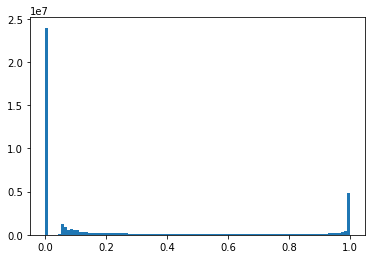

In [16]:
plt.hist(ret[2].numpy().flatten(), bins=np.linspace(0,1,100));

In [17]:
def loss(model, inputs, targets, epoch, training):
    pred_id, pred_momentum, _ = model(inputs)
    pred_inds = tf.argmax(pred_id, axis=-1)
    #mask_correct = (pred_inds==targets[:, 0])
    l1 = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
        tf.one_hot(tf.cast(targets[:, 0], tf.int32), depth=len(class_labels)), pred_id))
    l0 = 0*tf.reduce_mean(tf.keras.losses.mse(targets[:, 1:4], pred_momentum[:]))
    return l1 + l0

In [18]:
def grad(model, inputs, targets, epoch):
    with tf.GradientTape() as tape:
        loss_value = loss(model, inputs, targets, epoch, training=True)
        return loss_value, tape.gradient(loss_value, model.trainable_variables)

In [33]:
accum_vars = [tf.Variable(tf.zeros_like(tv.initialized_value()), trainable=False) for tv in model.trainable_variables]

for i in range(10):
    loss_tot = 0.0
    
    ibatch = 0
    
    true_ids = []
    pred_ids = []
    
    for Xelem, ygen in zip(Xs_training, ys_training):
        loss_value, grads = grad(model, Xelem, ygen, i)
        for igrad, gv in enumerate(grads):
            accum_vars[igrad].assign_add(gv)
        
        loss_tot += loss_value.numpy()
        if ibatch == 5:
            opt.apply_gradients([(accum_vars[igrad] / 5, model.trainable_variables[igrad]) for igrad in range(len(accum_vars))])
            ibatch = 0
            for igrad in range(len(accum_vars)):
                accum_vars[igrad].assign(tf.zeros_like(accum_vars[igrad]))

        pred_id, pred_momentum, dm = model(Xelem)
        pred_ids += [tf.argmax(pred_id, axis=-1).numpy()]
        true_ids += [ygen[:, 0]]
        ibatch += 1
    true_ids = np.concatenate(true_ids)
    pred_ids = np.concatenate(pred_ids)
    
    true_ids_testing = []
    pred_ids_testing = []
    loss_tot_testing = 0.0
    for Xelem, ygen in zip(Xs_testing, ys_testing):
        pred_id, pred_momentum, _ = model(Xelem)
        true_ids_testing += [ygen[:, 0]]
        pred_ids_testing += [tf.argmax(pred_id, axis=-1).numpy()]
    true_ids_testing = np.concatenate(true_ids_testing)
    pred_ids_testing = np.concatenate(pred_ids_testing)

    acc = accuracy_score(true_ids, pred_ids)
    acc_testing = accuracy_score(true_ids_testing, pred_ids_testing)
    print("epoch={epoch} loss={loss:.2f} acc={acc:.4f}/{acc_testing:.4f}".format(epoch=i, loss=loss_tot, acc=acc, acc_testing=acc_testing))

epoch=0 loss=220.12 acc=0.8198/0.8197
epoch=1 loss=217.86 acc=0.8210/0.8214
epoch=2 loss=217.35 acc=0.8212/0.8221
epoch=3 loss=216.78 acc=0.8215/0.8223
epoch=4 loss=216.34 acc=0.8218/0.8231
epoch=5 loss=215.48 acc=0.8224/0.8233
epoch=6 loss=215.27 acc=0.8225/0.8235
epoch=7 loss=214.84 acc=0.8229/0.8234
epoch=8 loss=213.99 acc=0.8232/0.8244
epoch=9 loss=213.28 acc=0.8235/0.8242


In [34]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    cm[np.isnan(cm)] = 0.0

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.2f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.ylabel('True label')
    plt.xlim(-1, len(target_names))
    plt.ylim(-1, len(target_names))
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.tight_layout()

In [35]:
true_ids_testing = np.array(true_ids_testing)
pred_ids_testing = np.array(pred_ids_testing)
msk = (true_ids_testing!=0) & (pred_ids_testing!=0)

In [36]:
cm = confusion_matrix(true_ids_testing[msk], pred_ids_testing[msk], range(1,len(class_labels)))

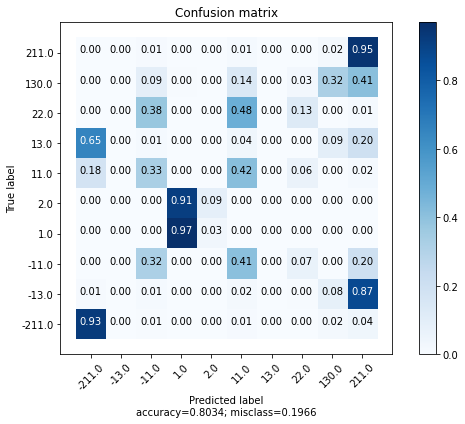

In [37]:
plot_confusion_matrix(cm, class_labels[1:], normalize=True)